# Proposed API

### geodesics/utils.py

In [1]:
import numpy as np

def energy(E, q, p, a, fac):
    """
    Utility function for `scipy.optimize.fsolve` 
    to compute Energy of the test particle

    Parameters
    ----------
    E : float
        Variable, which `scipy.optimize.fsolve` solves for
    q : array_like
        Length-3 Array, containing the initial 3-Position
    p: array_like
        Length-3 Array, containing the initial Covariant 3-Momentum
    a : float
        Dimensionless Spin Parameter of the Black Hole
    fac : float
        Norm of tangent vector to coordinate (4-Velocity/4-Momentum)
        `fac = 0` for null geodesics
        `fac = 0.5` for timelike geodesics

    """
    return -((a ** 4 * (E ** 2 - 2 * p[0] ** 2) - 8 * a * E * p[2] * q[0] - 
        2 * q[0] * (p[1] ** 2 * (-2 + q[0]) + p[0] ** 2 * (-2 + q[0]) ** 2 * q[0] - E ** 2 * q[0] ** 3) + 
        a ** 2 * (2 * p[2] ** 2 - 2 * p[1] ** 2 - 4 * p[0] ** 2 * (-2 + q[0]) * q[0] + 
        E ** 2 * q[0] * (2 + 3 * q[0])) + (a ** 2 + (-2 + q[0]) * q[0]) * (a ** 2 * E ** 2 * np.cos(2 * q[1]) - 
        2 * p[2] ** 2 * (1/(np.sin(q[1]) ** 2)) ))/((a ** 2 + (-2 + q[0]) * q[0]) * (a ** 2 + 2 * q[0] ** 2 + 
        a ** 2 * np.cos(2 * q[1])))) + 2 * fac


def sphToCart(r, th, ph):
    """
    Utility function to convert Spherical Polar 
    Coordinates to Cartesian Coordinates

    """
    xs = r * np.sin(th) * np.cos(ph)
    ys = r * np.sin(th) * np.sin(ph)
    zs = r * np.cos(th)

    return xs, ys, zs

### geodesics/geodesics.py

In [31]:
import warnings

import numpy as np
from scipy.optimize import fsolve

# from julia import KerrSolver

# Install einsteinpy_geodesics before running this
# Also, Julia has to be present on system path
from einsteinpy_geodesics import SolveSystem


class Geodesic:
    """
    Base Class for defining Geodesics
    Working in Geometrized Units (M-Units), with ``G = c = M = 1.``

    """

    def __init__(
        self,
        position,
        momentum,
        a=0.,
        mu=1.,
        end_lambda=100.,
        step_size=0.0005,
        time_like=True,
        return_cartesian=True,
    ):
        """
        Parameters
        ----------
        position : array_like
            Length-3 Array, containing the initial 3-Position
        momentum : array_like
            Length-3 Array, containing the initial Covariant 3-Momentum
        a : float
            Dimensionless Spin Parameter of the Black Hole
            Defaults to ``0.`` (Schwarzschild Black Hole)
        mu : float
            Dimensionless mass of the test particle
            Defaults to ``1.``
        end_lambda : float
            Affine Parameter value, where integration will end
            Equivalent to Proper Time for Timelike Geodesics
            Defaults to ``100.``
        step_size : float, optional
            Size of each geodesic integration step
            A fixed-step, symplectic VerletLeapfrog integrator is used
            Defaults to ``0.0005``
        time_like : bool
            Determines type of Geodesic
            ``True`` for Time-like geodesics
            ``False`` for Null-like geodesics
            Defaults to ``True``
        return_cartesian : bool, optional
            Whether to return calculated positions in Cartesian Coordinates
            This only affects the coordinates. The momenta dimensionless quantities,
            and are returned in Spherical Polar Coordinates.
            Defaults to ``True``

        """
        self.position = position
        self.momentum = momentum
        self.a = a
        self.mu = mu
        self.end_lambda = end_lambda
        self.step_size = step_size
        self.time_like = time_like
        self.return_cartesian = return_cartesian

        self._trajectory = self.calculate_trajectory()

    def __repr__(self):
        kind = "Null-like"
        if self.time_like:
            kind = "Time-like"

        coords = "Spherical Polar"
        if self.return_cartesian:
            coords = "Cartesian"

        return f"Geodesic Object:\n\
            Type = ({kind}),\n\
            Position = ({self.position}),\n\
            Covariant Momentum = ({self.momentum}),\n\
            Spin Parameter = ({self.a})\n\
            Test Particle Mass = ({self.mu})\n\
            Solver details = (\n\
                Step-size = ({self.step_size}),\n\
                End-Lambda = ({self.end_lambda})\n\
                Trajectory = (\n\
                    {self.trajectory}\n\
                ),\n\
                Output Position Coordinate System = ({coords})\n\
            )"

    def __str__(self):
        return self.__repr__()

    @property
    def trajectory(self):
        """
        Returns the trajectory of the test particle

        """
        return self._trajectory

    def calculate_trajectory(self):
        """
        Calculate trajectory in spacetime, according to Geodesic Equations

        Returns
        -------
        ~numpy.ndarray
            N-element numpy array, containing affine parameter 
            values, where the integration was performed
        ~numpy.ndarray
            Shape-(N, 6) numpy array, containing [x1, x2, x3, p_r, p_theta, p_phi] for each Lambda

        """
        # All quantities must be floats for error-free Julia operation
        a, mu = float(self.a), float(self.mu)
        end_lambda, step_size = float(self.end_lambda), float(self.step_size)
        q = [float(pos) for pos in self.position]
        p = [float(pos) for pos in self.momentum]

        fac = 0.5 if time_like else 0.

        # Getting Energy value, after solving guu.pd.pd = fac, where, 
        # 'u' denotes contravariant index and 'd' denotes covariant index
        E = float(fsolve(energy, 1., args=(q, p, a, fac,))[-1])

        params = [a, E, mu, fac]

        # Calling Julia routine to solve the system
        retcode, lambdas, vecs = SolveSystem( # KerrSolver.solveSystem( # #
            q,
            p,
            params,
            end_lambda,
            step_size
        )

        if retcode == "Terminated":
            warnings.warn(
                "Test particle has reached the Event Horizon. ", RuntimeWarning
            )

        if self.return_cartesian:
            xc = list()
            yc = list()
            zc = list()

            # Converting to Cartesian from Spherical Polar Coordinates
            # Note that momenta cannot be converted correctly, this way,
            # due to ambiguities in the signs of v_r and v_th (velocities)
            cart_vecs = list()
            for y in vecs:
                r, th, phi = y[0], y[1], y[2]
                cart_coords = sphToCart(r, th, phi)
                cart_vecs.append(np.hstack((cart_coords, y[3:])))

            return lambdas, np.array(cart_vecs)

        return lambdas, vecs

# Testing

In [44]:
# Testing

# WORKS
# q0 = [2.5, np.pi / 2, 0.]
# p0 = [0., -0.2, -2.]
# a = 0.9
# mu = 0.
# end_lambda=10.
# step_size=0.0005
# time_like=False
# return_cartesian=True

q0 = [10., np.pi / 2, 0.]
p0 = [0., 0., 3.5]
a = 0.
mu = 1.
end_lambda=90.
step_size=0.0005
time_like=True
return_cartesian=False

In [45]:
geod = Geodesic(
    position=q0,
    momentum=p0,
    a=a,
    mu=mu,
    end_lambda=end_lambda,
    step_size=step_size,
    time_like=time_like,
    return_cartesian=return_cartesian,
)

In [46]:
geod

Geodesic Object:
            Type = (Time-like),
            Position = ([10.0, 1.5707963267948966, 0.0]),
            Covariant Momentum = ([0.0, 0.0, 3.5]),
            Spin Parameter = (0.0)
            Test Particle Mass = (1.0)
            Solver details = (
                Step-size = (0.0005),
                End-Lambda = (90.0)
                Trajectory = (
                    (array([0.00000e+00, 5.00000e-04, 1.00000e-03, ..., 8.99990e+01,
       8.99995e+01, 9.00000e+01]), array([[ 1.00000000e+01,  1.57079633e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.50000000e+00],
       [ 1.00000000e+01,  1.57079633e+00, -1.75000000e-05,
         8.90625000e-07, -3.75048082e-21,  3.50000000e+00],
       [ 1.00000000e+01,  1.57079633e+00, -3.50000000e-05,
         1.78125000e-06, -7.50096165e-21,  3.50000000e+00],
       ...,
       [ 5.56932628e+00,  1.57079633e+00, -5.01935099e+00,
         9.86458953e-02, -1.07571521e-15,  3.50000000e+00],
       [ 5.56929467e+00

In [47]:
type(geod.trajectory)

tuple

In [51]:
geod.trajectory[1][0]

array([10.        ,  1.57079633,  0.        ,  0.        ,  0.        ,
        3.5       ])

In [48]:
geod.trajectory[1][1]

array([ 1.00000000e+01,  1.57079633e+00, -1.75000000e-05,  8.90625000e-07,
       -3.75048082e-21,  3.50000000e+00])

In [49]:
geod.trajectory[1][-1]

array([ 5.56926306e+00,  1.57079633e+00, -5.01946383e+00,  9.86457818e-02,
       -1.07573939e-15,  3.50000000e+00])

In [ ]:
geod.trajectory[1][:, 0]

In [24]:
xc = geod.trajectory[1][:, 0]
yc = geod.trajectory[1][:, 1]
zc = geod.trajectory[1][:, 2]

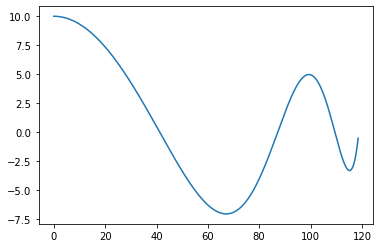

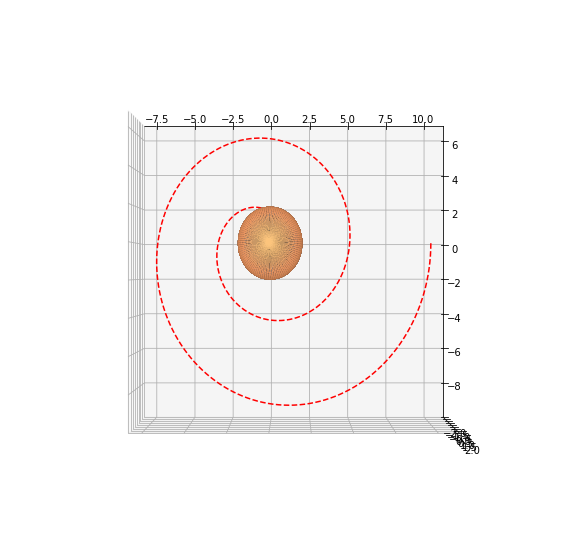

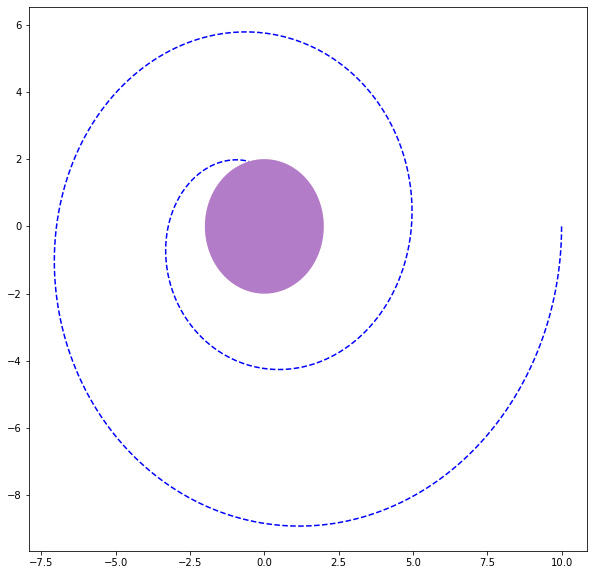

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

plt.plot(geod.trajectory[0], geod.trajectory[1][:, 0])

#####################################################################################
## Plotting BH
theta, phi = np.linspace(0, 2 * np.pi, 100), np.linspace(0, np.pi, 100)
THETA, PHI = np.meshgrid(theta, phi)

# Ergosphere
R_o = 1 + np.sqrt(1 - (a * np.cos(THETA) ** 2))

Xo = R_o * np.sin(PHI) * np.sin(THETA)
Yo = R_o * np.sin(PHI) * np.cos(THETA)
Zo = R_o * np.cos(PHI)

# Horizon
r_outer = 1 + np.sqrt(1 - a ** 2)

Xro = r_outer * np.sin(PHI) * np.cos(THETA)
Yro = r_outer * np.sin(PHI) * np.sin(THETA)
Zro = r_outer * np.cos(PHI)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.axes(projection="3d")
ax.view_init(azim=-90, elev=90)

ax.plot(xc, yc, zc, "r--")
ax.plot_surface(
    Xo, Yo, Zo, rstride=1, cstride=1, cmap=plt.get_cmap('Blues'),
    linewidth=0, antialiased=False, alpha=0.3)
ax.plot_surface(
    Xro, Yro, Zro, rstride=1, cstride=1, cmap=plt.get_cmap('copper'),
    linewidth=0, antialiased=False, alpha=0.3)

#####################################################################################
# Plotting in 2D
R_oh = 1 + np.sqrt(1 - (a * np.cos(theta) ** 2))
Xh = R_oh * np.sin(theta)
Yh = R_oh * np.cos(theta)

Xho = r_outer * np.sin(theta)
Yho = r_outer * np.cos(theta)

fig2 = plt.figure(figsize=(10,10))
ax2 = plt.axes()
ax2.fill(Xho, Yho, 'r', Xh, Yh, 'b', alpha=0.3)
ax2.plot(xc, yc, 'b--')

#####################################################################################